# Estimación de ICI mediante *counting vectors* a 16 GBd

## Inicialización

### Librerías



In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    GOOGLE_COLAB = True
    ROOT = "/content/drive/MyDrive/SOFA/ICI_Project"

    drive.mount('/content/drive')
    !cp {ROOT}"/sofa.py" "."
    !cp {ROOT}"/counting_vectors_16f.csv" "."
    !cp {ROOT}"/counting_vectors_16g.csv" "."
else:
    GOOGLE_COLAB = False
    ROOT = "."

Mounted at /content/drive


In [2]:
import sofa

import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as ker
import json
import os

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from collections import defaultdict

In [3]:
GPU = tf.config.list_physical_devices('GPU')
if len(GPU) > 0:
    print(f"Using GPU: {GPU}")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Funciones globales

In [4]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def estimation_model(
    layers_props_lst: list, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """ Compile a sequential model for regression purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def estimation_crossvalidation(X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks):
    """ Crossvalidation of an estimation network. """
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": [], "prod": []}
    scores["r2"] = {"train": [], "test": [], "prod": []}
    scores["rmse"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = estimation_model(layer_props, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, callbacks=callbacks, verbose=0
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        predictions_train = model.predict(X_train, verbose=0).flatten()
        # Predict using test values
        predictions_test = model.predict(X_test_kf, verbose=0).flatten()
        # Predict using production values
        predictions_prod = model.predict(X_prod_kf, verbose=0).flatten()

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": y_train, "Predicted ICI": predictions_train}
        )
        train_data_test = pl.DataFrame(
            {"ICI": y_test, "Predicted ICI": predictions_test}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": y_prod, "Predicted ICI": predictions_prod}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        mae_score_prod = mean_absolute_error(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        r2_score_prod = r2_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # RMSE
        rmse_score_train = mean_squared_error(
            train_data_train["ICI"], train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            train_data_test["ICI"], train_data_test["Predicted ICI"],
            squared=False
        )
        rmse_score_prod = mean_squared_error(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"],
            squared=False
        )

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["mae"]["prod"].append(mae_score_prod)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["r2"]["prod"].append(r2_score_prod)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        scores["rmse"]["prod"].append(rmse_score_prod)

    return scores


def test_estimation_model(data, data_prod, n_splits, max_neurons, activations,
                          use_osnr=True, loss_fn="mean_absolute_error"):
    """ Test a spectral spacing estimation model with given parameters. """
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''}")
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]

    return estimation_crossvalidation(X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks)

def plot_results(x_values, scores, xlabel, log):
    plt.figure(figsize=(8, 6), layout="constrained")
    plt.scatter(x_values, scores)
    plt.plot(x_values, scores)
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    if log:
        plt.xscale("log", base=2)
    plt.grid(True)
    plt.show()

### Leer CV y separarlos

In [5]:
if GOOGLE_COLAB:
    cv16f_file = "counting_vectors_16f.csv"
    cv16g_file = "counting_vectors_16g.csv"
else:
    cv16f_file = "../../Databases/16GBd/counting_vectors_16f.csv"
    cv16g_file = "../../Databases/16GBd/counting_vectors_16g.csv"


cv16f = pl.read_csv(cv16f_file, has_header=False, dtypes=[pl.Float64])
cv16g = pl.read_csv(cv16g_file, has_header=False, dtypes=[pl.Float64])

## FCM

In [6]:
# Show the original dataframe
cv16f

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [7]:
# Shuffle the dataframe
cv16f_shuffled = cv16f.sample(n=len(cv16f), shuffle=True, seed=1036681523)
print(cv16f_shuffled)

shape: (680, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 0

In [8]:
# Extract 10% of the data to use later for "production" testing
cv16f_prod = cv16f_shuffled[:int(len(cv16f_shuffled)*0.1)]
print(cv16f_prod)

shape: (68, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1.

In [9]:
# Use the rest of the data for normal testing
cv16f_new = cv16f_shuffled[int(len(cv16f_shuffled)*0.1):]

### Evaluación de hiperparámetros

Se evaluará una combinación de parámetros:
- Número de neuronas máximas por capa (8, 16, 32, 64, 128, 256, 512, 1024).
- Número de capas (1, 2, 3).
- Combinación de funciones de activación (ReLu, tanh, sigmoid).
- El usar o no la OSNR como característica adicional.

Los resultados tendrán la siguiente estructura:
```
{"xyz": {"n_neurons": {"osnr/wo_osnr": results}}}
```
Donde xyz serán las iniciales de las combinaciones de funciones de activación, n_neurons será el número de neuronas máximo, osnr/wo_osnr será la indicación de si se usó o no el OSNR como característica y results será el objeto resultante que contiene todos los resultados.

In [10]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]

combinations = [
    [list(subset) for subset in product(functs, repeat=n)]
    for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [11]:
try:
    cv16f_reg_results = sofa.load_hdf5(f"{ROOT}/cv16f_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16f_reg_results = defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy)

# Evaluar
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {"data": cv16f_new, "data_prod": cv16f_prod, "n_splits": 5, "max_neurons": int(neurons), "activations": activations, "use_osnr": True if osnr == "osnr" else False}
            act_fn_name = "".join([s[0] for s in activations])
            if cv16f_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [utils.serialize_keras_object(model) for model in results["model"]]
                # Save serialized model for serialization
                cv16f_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16f_reg_results, f"{ROOT}/cv16f_reg_results.h5")
                print("Results saved!")

### Resultados

In [12]:
def get_avg_score(results, target_value, target="neurons", metric="mae", score="test"):
    mae_lst = []
    for activations in hidden_layers:
        if target == "layers" and len(activations) != target_value:
            continue
        for neurons in max_neurons:
            if target == "neurons" and neurons != target_value:
                continue
            for osnr in osnr_lst:
                if target == "osnr" and osnr != target_value:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"]))
    return mae_lst


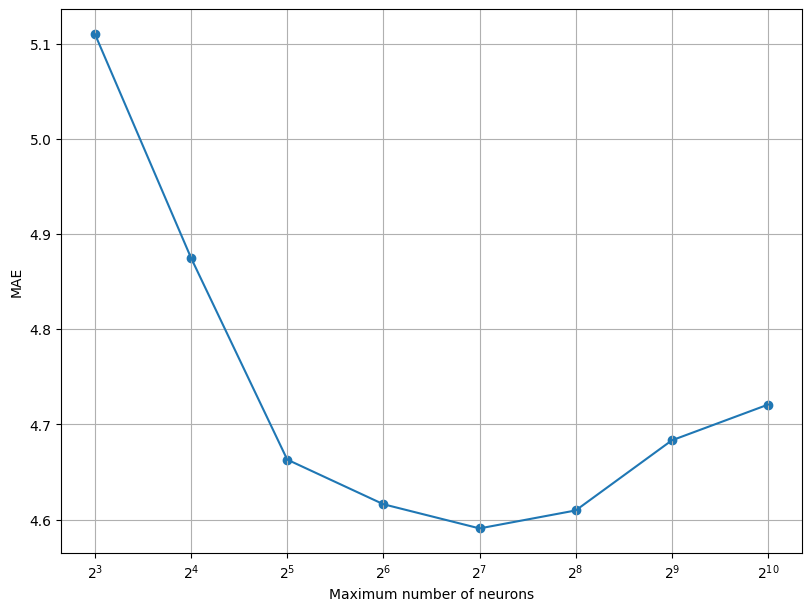

In [13]:
neurons_avg_results = [np.mean(get_avg_score(cv16f_reg_results, neurons, target="neurons", metric="mae", score="test")) for neurons in max_neurons]
x = list(map(int, max_neurons))
plot_results(x, neurons_avg_results, "Maximum number of neurons", log=True)

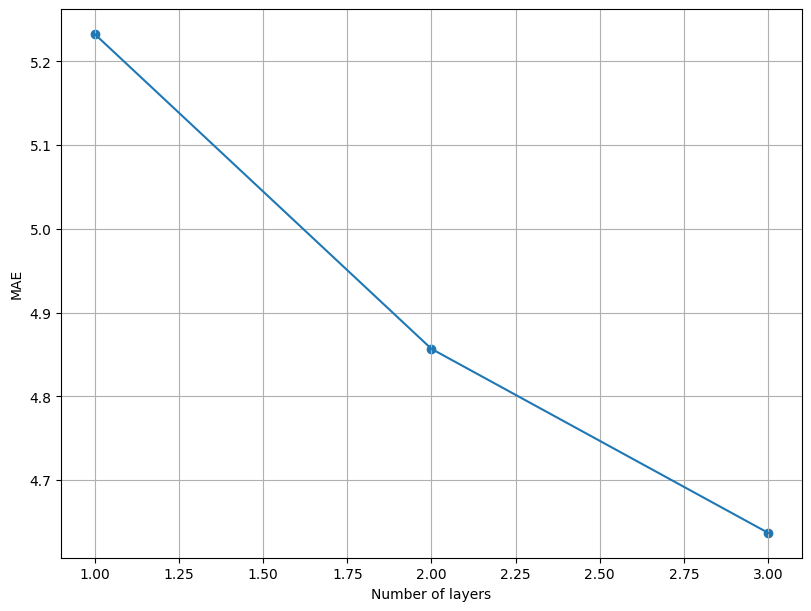

In [14]:
layers_avg_results = [np.mean(get_avg_score(cv16f_reg_results, layers, target="layers", metric="mae", score="test")) for layers in range(1, 4)]
x = range(1, 4)
plot_results(x, layers_avg_results, "Number of layers", log=False)

In [15]:
osnr_avg_results = [np.mean(get_avg_score(cv16f_reg_results, osnr, target="osnr", metric="mae", score="test")) for osnr in ["osnr", "wo_osnr"]]
print(f"Con OSNR  Sin OSNR")
print(f"{osnr_avg_results[0]:.3f}       {osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
4.232       5.235


### Ordenar modelos por puntaje

In [16]:
# Find better model by test score
def get_better_models(results, metric="mae", score="test"):
    scores = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                coll = cv16f_reg_results[act_fn_name][neurons][osnr][metric][score]
                if isinstance(coll, defaultdict):
                    continue
                score_value = np.mean(coll)
                scores.append((score_value, [act_fn_name, neurons, osnr]))
    scores.sort(key=lambda x: x[0])
    return pl.dataframe.DataFrame(scores)

In [17]:
better_models_df = get_better_models(cv16f_reg_results, metric="mae", score="test")
better_models_df.head(25)

column_0,column_1
f64,list[str]
2.80612,"[""tst"", ""512"", ""osnr""]"
2.807177,"[""tss"", ""32"", ""osnr""]"
2.818996,"[""stt"", ""256"", ""osnr""]"
2.83914,"[""tss"", ""256"", ""osnr""]"
2.845752,"[""tst"", ""128"", ""osnr""]"
2.879023,"[""rtt"", ""256"", ""osnr""]"
2.881343,"[""tss"", ""64"", ""osnr""]"
2.891847,"[""tss"", ""1024"", ""osnr""]"
2.893098,"[""rrs"", ""256"", ""osnr""]"


## GKM

In [18]:
# Show the original dataframe
cv16g

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [19]:
# Shuffle the dataframe
cv16g_shuffled = cv16g.sample(n=len(cv16g), shuffle=True, seed=1036681523)
print(cv16g_shuffled)

shape: (680, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 0

In [20]:
# Extract 10% of the data to use later for "production" testing
cv16g_prod = cv16g_shuffled[:int(len(cv16g_shuffled)*0.1)]
print(cv16g_prod)

shape: (68, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1.

In [21]:
# Use the rest of the data for normal testing
cv16g_new = cv16g_shuffled[int(len(cv16g_shuffled)*0.1):]

### Evaluación de hiperparámetros

In [ ]:
try:
    cv16g_reg_results = sofa.load_hdf5(f"{ROOT}/cv16g_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16g_reg_results = defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy)

# Evaluar
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {"data": cv16g_new, "data_prod": cv16g_prod, "n_splits": 5, "max_neurons": int(neurons), "activations": activations, "use_osnr": True if osnr == "osnr" else False}
            act_fn_name = "".join([s[0] for s in activations])
            if cv16g_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [utils.serialize_keras_object(model) for model in results["model"]]
                # Save serialized model for serialization
                cv16g_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16g_reg_results, f"{ROOT}/cv16g_reg_results.h5")
                print("Results saved!")

[{'units': 8, 'activation': 'relu'}, {'units': 4, 'activation': 'relu'}, {'units': 2, 'activation': 'relu'}] + OSNR


### Resultados

In [ ]:
neurons_avg_results = [np.mean(get_avg_score(cv16g_reg_results, neurons, target="neurons", metric="mae", score="test")) for neurons in max_neurons]
x = list(map(int, max_neurons))
plot_results(x, neurons_avg_results, "Maximum number of neurons", log=True)

In [ ]:
layers_avg_results = [np.mean(get_avg_score(cv16g_reg_results, layers, target="layers", metric="mae", score="test")) for layers in range(1, 4)]
x = range(1, 4)
plot_results(x, layers_avg_results, "Number of layers", log=False)

In [ ]:
osnr_avg_results = [np.mean(get_avg_score(cv16g_reg_results, osnr, target="osnr", metric="mae", score="test")) for osnr in ["osnr", "wo_osnr"]]
print(f"Con OSNR  Sin OSNR")
print(f"{osnr_avg_results[0]:.3f}       {osnr_avg_results[1]:.3f}")

### Ordenar modelos por puntaje

In [ ]:
better_models_df = get_better_models(cv16g_reg_results, metric="mae", score="test")
better_models_df.head(25)